# Gaussian Mixture Model

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import sys
from sklearn import mixture
from sklearn import preprocessing
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import feature_extraction as fe
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
from IPython.display import HTML

In [2]:
client = mongo_client.CERNMongoClient()
df = client.query_resample("^MKI.(A|B).*B1:.*", '1T')

Fetching data for pattern ^MKI.(A|B).*B1:.*
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.B5L2.B1:PRESSURE
Fetching data for MKI.B5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.A5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.B5L2.B1:PRESSURE_INT
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.B5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:PRESSURE_INT
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.A5L2.B1:PRESSURE
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_DOWN


In [3]:
display("Original data size: %s" % df.shape[0])
df_f = ad_pp.filter_extremes(df)
display("New data size: %s" % df_f.shape[0])

'Original data size: 122400'

'New data size: 122399'

Above code filters away pressure outside of [9x10^-12,  5x10^-9] mbar, magnet temperature outside of [18, 60] degrees Celcius and tube temperature outside of [18, 120] degrees Celcius. The resulting data will be used to fit the model. The original data will be used to detect anomalies.

In [4]:
data_filtered = preprocessing.scale(df_f.values)
data_unfiltered = preprocessing.scale(df.values)
clf = mixture.GaussianMixture(n_components=7, covariance_type='full')
clf.fit(data_filtered)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [5]:
log_probs = clf.score_samples(data_unfiltered)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())

'Log probs mean: -28.2958291058'

'Log probs min: -177146.381633'

'Log probs max: 10.6568250806'

1 point so extreme that it heavily influences outcome.

In [6]:
log_probs = clf.score_samples(data_filtered)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())
pct = np.percentile(log_probs, 1)
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]
binwidth = 10
plt.figure()
plt.hist(anomaly_log_probs, bins=np.arange(-200, max(anomaly_log_probs) + binwidth, binwidth));
plt.title("Fig1: histogram of log probabilities")
plt.xlabel('Weighted log probabilities')
plt.ylabel('count')

'Log probs mean: 12.1243661862'

'Log probs min: -1770.7915863'

'Log probs max: 37.7245315048'

Above plot shows the histogram of the 1 percent most anomalous datapoints above -200 (removed for clarity, plot would be very stretched over x axis). This gives an indication for the threshold.

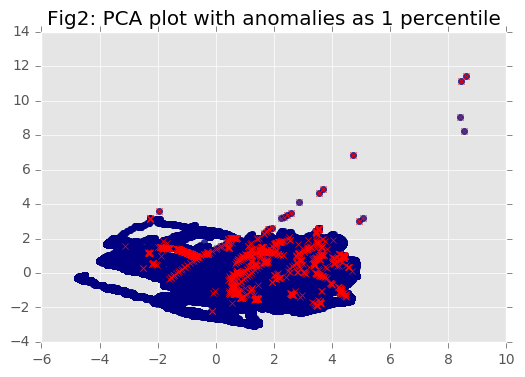

In [7]:
pca = PCA.create_pca(n_components=2)
pca_data = PCA.transform_data(data_filtered, pca)
PCA.plot_anomalies(pca_data, idx[0], "Fig2: PCA plot with anomalies as 1 percentile")

Remarks:
- bottom "band" was detected as anomaly in previous notebook, not anymore by training on all the data instead of 50/50 split

In [79]:
log_probs_df = pd.DataFrame(data=log_probs, index=df_f.index)
anomaly_log_probs_df = log_probs_df.iloc[idx[0].tolist()]
min30 = fe.sliding_window_mean(log_probs_df, 'T', 30)

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
log_probs_df.plot(ax=axes, color='b')
anomaly_log_probs_df.plot(ax=axes, color='r')
min30.plot(ax=axes,color='g')
labels = ["all log probs", "anomaly log probs", "30Min"]
axes.legend(labels)
axes.set_ylabel("log prob")
axes.set_title("Fig3: Sliding window mean for log probs")

The blue line are all the log probabilities from the GMM. Red is the 1 pct which could be anomalies. Green is a sliding window of 30 min over blue. These are already logarithmic, but still 3 very low points which make the plot unclear.

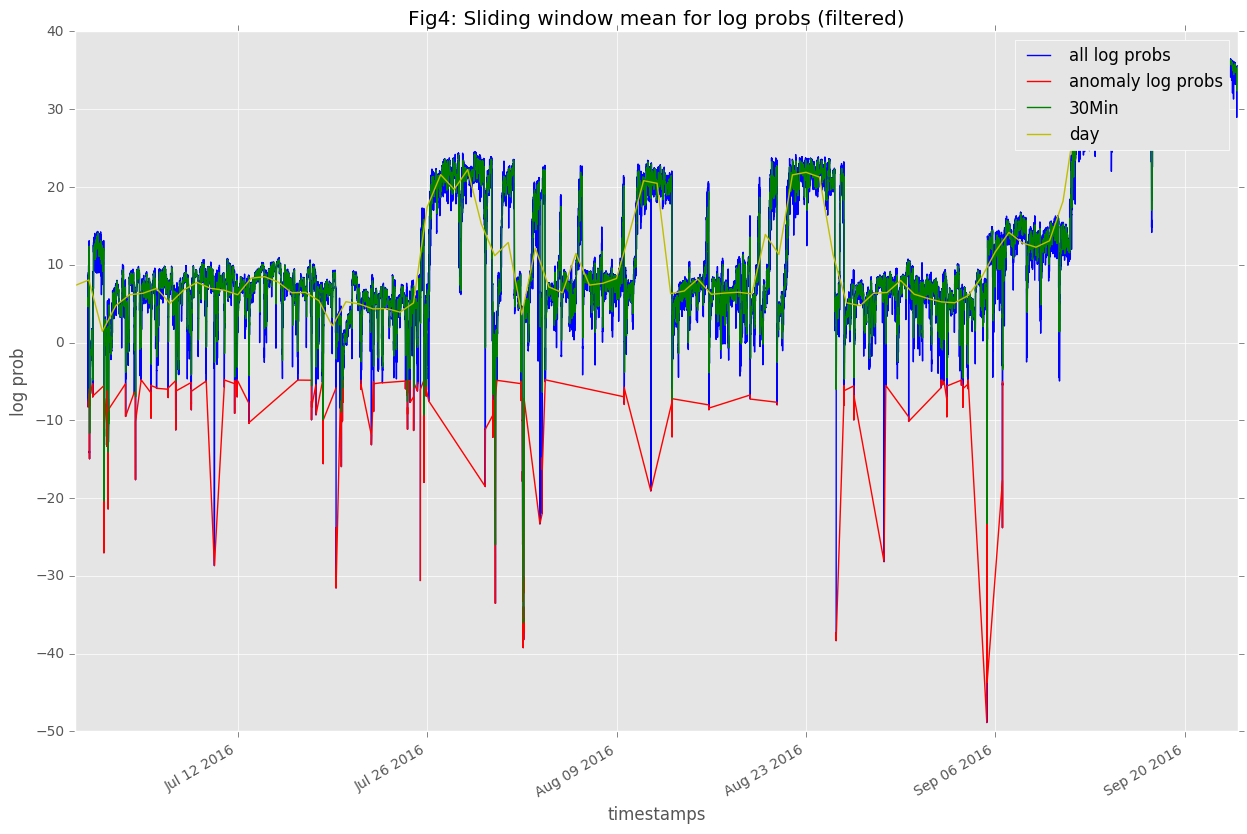

In [81]:
log_probs_df2 = log_probs_df[log_probs_df>-50]
anomaly_log_probs_df2 = anomaly_log_probs_df[anomaly_log_probs_df>-50]
min30 = fe.sliding_window_mean(log_probs_df2, 'T', 30)
day = fe.sliding_window_mean(log_probs_df2, 'D', 1)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
log_probs_df2.plot(ax=axes, color='b')
anomaly_log_probs_df2.plot(ax=axes, color='r')
min30.plot(ax=axes, color='g')
day.plot(ax=axes, color='y')
labels = ["all log probs", "anomaly log probs", "30Min", "day"]
axes.legend(labels)
axes.set_ylabel("log prob")
axes.set_title("Fig4: Sliding window mean for log probs (filtered)")

Figure 4 is identical to figure 3, but only with log probabilities above 50. This threshold was decided by figure 1. A possible way to detect anomalies would be to take the difference between the measured anomaly and its dayly slided window.

In [82]:
idx2 = np.argpartition(log_probs, 20) #first 20 elements will be the indexes of smallest elements
idx2 = idx2[:21]
# gives only 4 days with anomalies

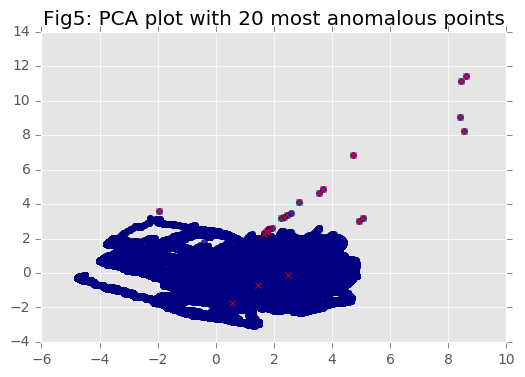

In [87]:
PCA.plot_anomalies(pca_data, idx2, "Fig5: PCA plot with 20 most anomalous points")

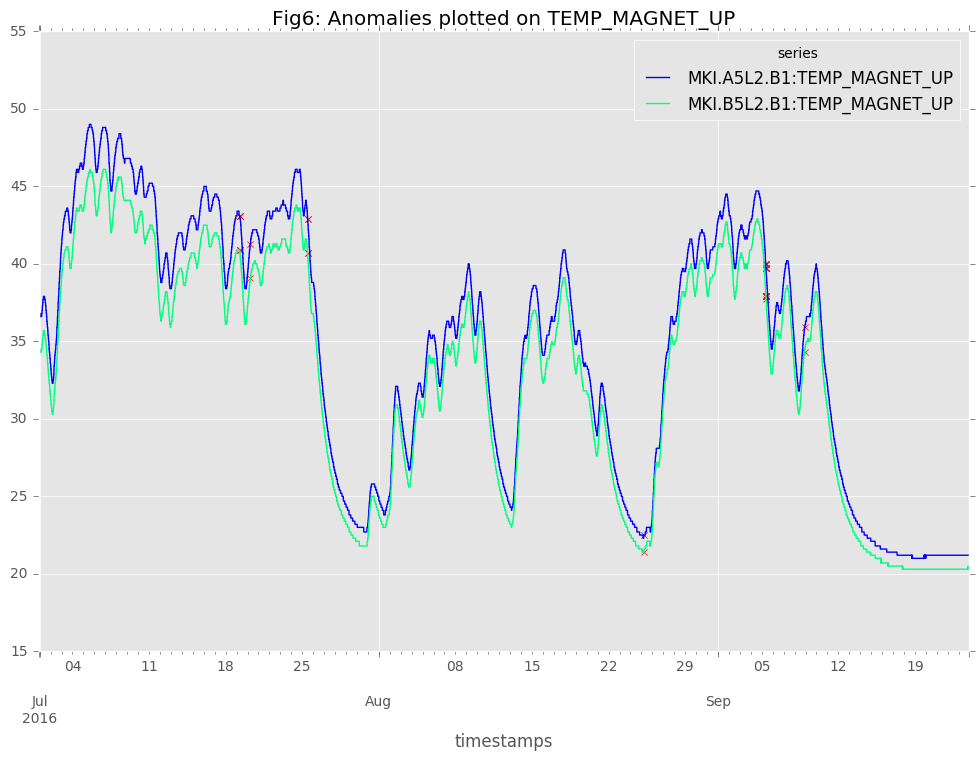

In [85]:
results.plot_anomalies_timeseries(df, idx2, "TEMP_MAGNET_UP", "Fig6: Anomalies plotted on TEMP_MAGNET_UP")

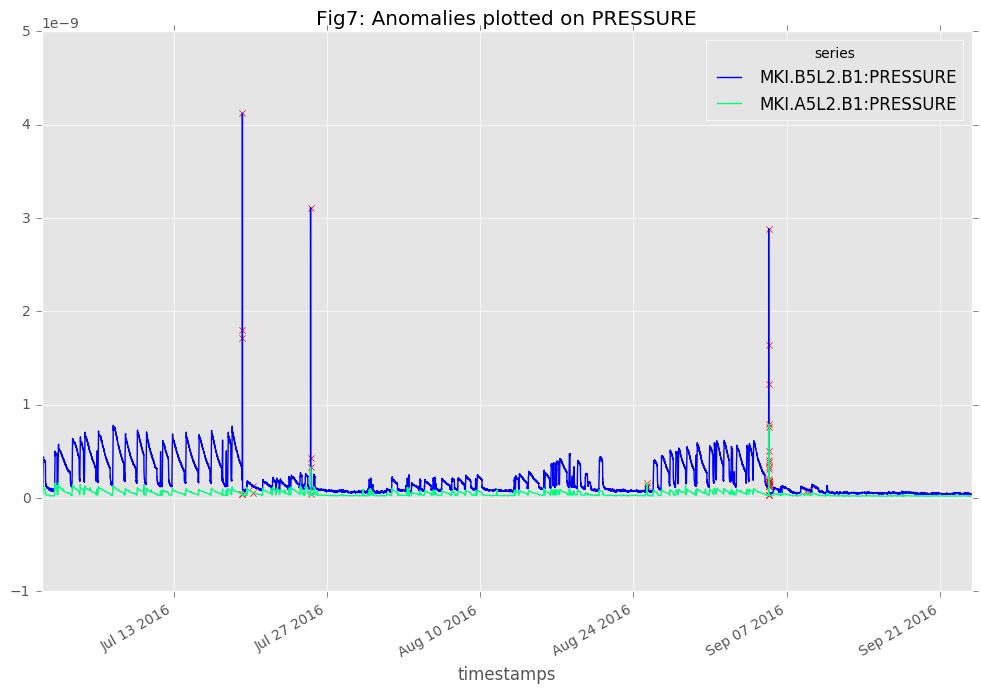

In [86]:
results.plot_anomalies_timeseries(df_f, idx2, "PRESSURE", "Fig7: Anomalies plotted on PRESSURE")
# passing filtered df else, 1 big spike and flatline
# indexes are technically off by 1 now